Для сервиса по продаже автомобилей разрабатывается система по прогнозированию цены автомобиля

Заказчику важны:

- качество предсказания;
- скорость предсказания;
- время обучения.

In [1]:
import pandas as pd

from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV

from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler

import matplotlib.pyplot as plt 
import seaborn as sns

from sklearn.model_selection import cross_val_score
import random

# 1. Подготовка данных

In [2]:
data=pd.read_csv('datasets/autos.csv')
data.head()

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [3]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [4]:
#дропнем ненужные столбцы с датами
data.drop(['DateCrawled','DateCreated', 'LastSeen'],axis=1,inplace=True)

<div class="alert alert-block alert-success">
Верно, эти признаки не нужны.
</div>

<div class="alert alert-block alert-danger">
Есть еще 2 лишних признака. Посчитай, сколько уникальных значений принимает каждый признак, это должно помочь.
</div>

In [5]:
data['VehicleType'].value_counts()

sedan          91457
small          79831
wagon          65166
bus            28775
convertible    20203
coupe          16163
suv            11996
other           3288
Name: VehicleType, dtype: int64

In [6]:
#Может там реально продавали раритеты
data['RegistrationYear'].value_counts().reset_index().sort_values(by='index').head(20)

,index,RegistrationYear
60,1000,37
129,1001,1
118,1039,1
95,1111,3
127,1200,1
85,1234,4
131,1253,1
130,1255,1
110,1300,2
126,1400,1


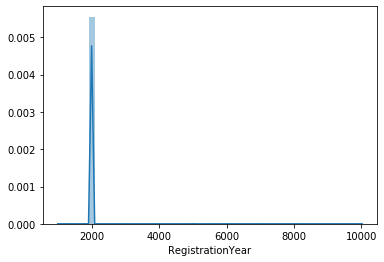

In [7]:
#Тут куча аномальных значений
sns.distplot(data['RegistrationYear'])

In [8]:
#Пустых значений в этом столбце нет
data['RegistrationYear'].isna().sum()

0

In [9]:
#Выбросим все лишние даты
data=data.query('1970<=RegistrationYear<2021')

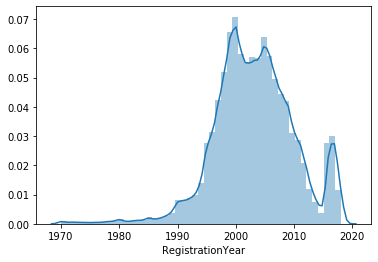

In [10]:
sns.distplot(data['RegistrationYear'])

In [11]:
data.Gearbox.value_counts()

manual    267478
auto       66101
Name: Gearbox, dtype: int64

In [12]:
#Devel Sixteen (5000 л. с.) самый мощный двигатель, но у нас же не спорт кары
data.Power.value_counts().reset_index().sort_values(by='index')

,index,Power
0,0,39579
229,1,33
304,2,10
315,3,8
239,4,30
...,...,...
473,17932,1
484,19208,1
487,19211,1
606,19312,1


In [13]:
data=data.query('Power<600')

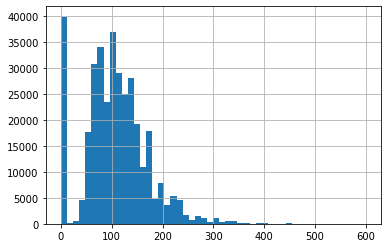

In [14]:
data.Power.hist(bins=50)

Строки с 0 мощностью обрабатывать не будем, так как иногда не известно какая у машины мощность, а заполнять медианой как-то неправльно, так как для градиентного бустинга это параметр важен и мы можем создать ошибку второго рода.

In [15]:
data.Model.value_counts()

golf                  29192
other                 23850
3er                   19738
polo                  13044
corsa                 12545
                      ...  
serie_2                   5
rangerover                4
serie_3                   4
range_rover_evoque        2
serie_1                   2
Name: Model, Length: 250, dtype: int64

In [16]:
data.Kilometer.value_counts()

150000    237666
125000     36350
100000     14711
90000      11485
80000       9986
70000       8519
60000       7371
50000       6159
5000        6002
40000       4864
30000       4379
20000       3925
10000       1132
Name: Kilometer, dtype: int64

In [17]:
data.RegistrationMonth.value_counts().reset_index().sort_values(by='index')

,index,RegistrationMonth
0,0,36862
10,1,23022
12,2,21183
1,3,34236
3,4,29170
4,5,29047
2,6,31354
5,7,26996
11,8,22552
9,9,23737


In [18]:
data.FuelType.value_counts()

petrol      215216
gasoline     98591
lpg           5302
cng            562
hybrid         231
other          187
electric        88
Name: FuelType, dtype: int64

In [19]:
data.Brand.value_counts()

volkswagen        76764
opel              39751
bmw               36835
mercedes_benz     31890
audi              29405
ford              25013
renault           17881
peugeot           10974
fiat               9559
seat               6895
mazda              5606
skoda              5489
smart              5240
citroen            5112
nissan             4935
toyota             4600
hyundai            3583
mini               3195
volvo              3168
mitsubishi         3014
sonstige_autos     2973
honda              2812
kia                2462
suzuki             2321
alfa_romeo         2298
chevrolet          1704
chrysler           1422
dacia               899
daihatsu            806
subaru              757
porsche             736
jeep                657
daewoo              541
land_rover          539
saab                525
trabant             518
jaguar              497
rover               484
lancia              464
lada                225
Name: Brand, dtype: int64

In [20]:
data.NotRepaired.value_counts()

no     246295
yes     35867
Name: NotRepaired, dtype: int64

In [21]:
#Столбец просто пустой, поэтому дропнем его
data.NumberOfPictures.value_counts()

0    352549
Name: NumberOfPictures, dtype: int64

In [22]:
data.drop(['NumberOfPictures'],axis=1,inplace=True)

In [23]:
data.PostalCode.value_counts()

10115    818
65428    613
66333    342
32257    317
44145    315
        ... 
96367      1
25599      1
55499      1
55432      1
63874      1
Name: PostalCode, Length: 8142, dtype: int64

In [24]:
#Этот столбец тоже мало информативен
data.drop('PostalCode', axis=1, inplace=True)

In [25]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
0,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no


In [26]:
#В данных столбцах есть пропуски 
data.isna().sum()

Price                    0
VehicleType          37068
RegistrationYear         0
Gearbox              19328
Power                    0
Model                19131
Kilometer                0
RegistrationMonth        0
FuelType             32372
Brand                    0
NotRepaired          70387
dtype: int64

Пустые значения в столбце NotRepaired заполним новым значением unknown, который соответствует ситуации продажи автомобиля со вторых рук

In [27]:
data['NotRepaired'].fillna('unknown', inplace=True)

In [28]:
data.isna().sum()

Price                    0
VehicleType          37068
RegistrationYear         0
Gearbox              19328
Power                    0
Model                19131
Kilometer                0
RegistrationMonth        0
FuelType             32372
Brand                    0
NotRepaired              0
dtype: int64

Заполнять пропуски в столбце VehicleType нельзя, так как у нас нет информации о его связях с другими признаками, поэтому просто дропнем

In [29]:
data['VehicleType'].value_counts()

sedan          90927
small          79644
wagon          65057
bus            28716
convertible    20072
coupe          15970
suv            11905
other           3190
Name: VehicleType, dtype: int64

In [30]:
data=data[~data['VehicleType'].isna()]

In [31]:
data=data[~data.VehicleType.isna()]

In [32]:
#В данных столбцах есть пропуски 
data.isna().sum()

Price                    0
VehicleType              0
RegistrationYear         0
Gearbox               9668
Power                    0
Model                12500
Kilometer                0
RegistrationMonth        0
FuelType             15398
Brand                    0
NotRepaired              0
dtype: int64

In [33]:
gearbox_unique=data['Gearbox'].value_counts()
gearbox_unique

manual    243764
auto       62049
Name: Gearbox, dtype: int64

In [34]:
probability=gearbox_unique[0]/(gearbox_unique[0]+gearbox_unique[1])
probability

0.7971014966662634

In [35]:
def bernoulli_trail(p):
    return 'manual' if random.random()<p else 'auto'

def fillGearbox(row):
    if pd.isnull(row['Gearbox']):
        return bernoulli_trail(probability)
    else:
        return row['Gearbox']

In [36]:

#Пропуски в коробках передач заполним случайными величинами, полученными по распредеелению бернулли
data['Gearbox']=data.apply(fillGearbox, axis=1)   

In [37]:
#В данных столбцах есть пропуски 
data.isna().sum()

Price                    0
VehicleType              0
RegistrationYear         0
Gearbox                  0
Power                    0
Model                12500
Kilometer                0
RegistrationMonth        0
FuelType             15398
Brand                    0
NotRepaired              0
dtype: int64

In [38]:
#Остальных пропусков мало, поэтому дропнем их
data.dropna(inplace=True)

<div class="alert alert-block alert-info">
Сколько пропусков? В каких столбцах? Лучше их было заполнить.
    
Все ли признаки принимают корректные значения, нет ли аномалий? Следовало исследовать этот вопрос отдельно.
</div>

In [39]:
#Стоимость до 100 евро следует выбросить, мы же не повозки продаём
data['Price'].value_counts().reset_index().sort_values(by='index').head(100)

,index,Price
0,0,5252
155,1,519
1165,2,6
1562,3,3
1090,5,8
...,...,...
3078,202,1
3038,205,1
1996,209,2
1145,210,6


In [40]:
data=data.query('Price>100')

In [41]:
data.head()

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no


In [42]:
data.reset_index(drop=True, inplace=True)

In [43]:
#Выделим столбцы с категориальными признаками
cat_features=['VehicleType','Gearbox','Model','FuelType','Brand','NotRepaired']
data_cat_features=data[cat_features]
data_not_cat_features=data.drop(cat_features, axis=1)

In [44]:
#Специально для линейной регрессии
data_for_linear=data.copy()

In [45]:
#Кодируем категориальные признаки
encoder=OrdinalEncoder()
data_cat_features=pd.DataFrame(encoder.fit_transform(data_cat_features), columns=data_cat_features.columns)
#Объединим DataFrames
data=pd.merge(data_not_cat_features,data_cat_features,
        left_index=True, right_index=True)

In [46]:
data_for_linear=pd.get_dummies(data_for_linear[cat_features], drop_first=True)
data_for_linear=pd.merge(data_not_cat_features,data_for_linear,
        left_index=True, right_index=True)

<div class="alert alert-block alert-danger">
    
Кодирование требуется только для **категориальных** признаков.
</div>

In [47]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283580 entries, 0 to 283579
Data columns (total 11 columns):
Price                283580 non-null int64
RegistrationYear     283580 non-null int64
Power                283580 non-null int64
Kilometer            283580 non-null int64
RegistrationMonth    283580 non-null int64
VehicleType          283580 non-null float64
Gearbox              283580 non-null float64
Model                283580 non-null float64
FuelType             283580 non-null float64
Brand                283580 non-null float64
NotRepaired          283580 non-null float64
dtypes: float64(6), int64(5)
memory usage: 23.8 MB


In [48]:
data['Price'].describe()

count    283580.000000
mean       4909.589333
std        4603.586838
min         101.000000
25%        1400.000000
50%        3250.000000
75%        6999.000000
max       20000.000000
Name: Price, dtype: float64

# 2. Обучение моделей

In [49]:
train, test=train_test_split(data,random_state=0)
train_linear, test_linear=train_test_split(data_for_linear,random_state=0)

<div class="alert alert-block alert-info">
При вызове train_test_split задавай random_state для воспроизводимости результатов.
</div>

In [50]:
X_train=train.drop('Price', axis=1)
y_train=train['Price']

X_test=test.drop('Price', axis=1)
y_test=test['Price']

X_train_linear=train_linear.drop('Price', axis=1)
y_train_linear=train_linear['Price']

X_test_linear=test_linear.drop('Price', axis=1)
y_test_linear=test_linear['Price']

In [51]:
#Количественные признаки
quan_features=X_train.drop(cat_features,axis=1).columns

In [52]:
#Масштабируем только числовые признаки
scaler=StandardScaler()
X_train[quan_features]=scaler.fit_transform(X_train[quan_features])
X_test[quan_features]=scaler.transform(X_test[quan_features])

In [53]:
#Масштабируем только числовые признаки для линейной регрессии
X_train_linear[quan_features]=scaler.transform(X_train_linear[quan_features])
X_test_linear[quan_features]=scaler.transform(X_test_linear[quan_features])

<div class="alert alert-block alert-danger">
    
Масштабирование применяется только для **числовых** признаков.
    
Результаты метода transform нужно сохранять, иначе никакого преобразования признаков не происходит (можешь проверить, после выполнения кода выше таблицы X_train и X_test остались без изменений).
</div>

<div class="alert alert-block alert-success">
Правильно, scaler настраивается (fit) только по обучающей выборке, для тестовой выборки следует применять метод transform.
</div>

In [54]:
%%time
linear_model=LinearRegression()
scores=cross_val_score(linear_model, X_train_linear,y_train_linear,scoring='neg_mean_squared_error', n_jobs=-1,cv=5)
print('Линейная регрессия:',abs(scores.mean())**0.5)

Линейная регрессия: 2476.985130553877
Wall time: 10.6 s


<div class="alert alert-block alert-danger">
Линейная регрессия использует арифметические операции над признаками, поэтому для нее применять порядковое кодирование категориальных признаков некорректно, следует использовать OHE-кодирование.
</div>

<div class="alert alert-block alert-info">

В целом, возможны 2 способа настройки и выбора моделей: 

1) делим выборку на 2 части – обучающую и тестовую. Для всех моделей на обучающей выборке проводим кросс-валидацию, лучшую модель выбираем по качеству на кросс-валидации. В конце оцениваем качество лучшей модели на тестовой выборке. 
    
2) делим выборку на 3 части – обучающую, валидационную, тестовую. На обучающей выборке настраиваем модели, лучшую модель выбираем по качеству на валидационной выборке. Качество лучшей модели оцениваем на тестовой выборке.
    
Качество лучшей модели на валидационной выборке/на кросс-валидации получится оптимистически смещенным, для получения несмещенной оценки качества и нужна тестовая выборка.

Твои эксперименты ближе к способу №1, поэтому замечания ниже относятся к этому варианту. 

</div>

<div class="alert alert-block alert-danger">
Для модели линейной регрессии, как и для остальных моделей, проведи кросс-валидацию и измерь качество модели на кросс-валидации.
</div>

In [55]:
%%time
forest_base_model=RandomForestRegressor()
forest_params={'n_estimators':[x for x in range(5,200,5)],
              'max_depth':[x for x in range(1,5,1)]}
forest_model=GridSearchCV(estimator=forest_base_model,
                         param_grid=forest_params,
                         scoring='neg_mean_squared_error',
                         n_jobs=-1,
                         cv=5)
forest_model.fit(X_train, y_train)
print('Случайный лес:',abs(forest_model.best_score_)**0.5)

Случайный лес: 2693.754378729321
Wall time: 13min 9s


<div class="alert alert-block alert-success">
Молодец, что настраиваешь гиперпараметры, это правильно.
</div>

<div class="alert alert-block alert-danger">
Выведи на экран качество на кросс-валидации (forest_model.best_score_). Замечание относится и к моделям ниже.
</div>

In [56]:
%%time
tree_base_model=DecisionTreeRegressor()
tree_params={'max_depth':[x for x in range(1,10,2)]}
tree_model=GridSearchCV(estimator=tree_base_model,
                         param_grid=tree_params,
                         scoring='neg_mean_squared_error',
                         n_jobs=-1,
                         cv=5)
tree_model.fit(X_train, y_train)
print('Решающее дерево:',abs(tree_model.best_score_)**0.5)

Решающее дерево: 2001.708929486353
Wall time: 2.13 s


In [57]:
%%time
gb_base_model=LGBMRegressor()
gb_params={'max_depth':[x for x in range(2,60,5)],
            'n_estimators':[x for x in range(5,200,5)],
            'learning_rate':[x/100 for x in range(10,80,10)]}
gb_model=GridSearchCV(estimator=gb_base_model,
                         param_grid=gb_params,
                         scoring='neg_mean_squared_error',
                         n_jobs=-1,
                         cv=5)
gb_model.fit(X_train, y_train)
print('Градиентный бустинг:',abs(gb_model.best_score_)**0.5)

Градиентный бустинг: 1539.5423704578266
Wall time: 1h 19min 39s


# 3. Анализ моделей

<div class="alert alert-block alert-danger">
В этом разделе обучи каждую модель с лучшими гиперпараметрами (например, для случайного леса – это forest_model.best_estimator_) и измерь ее качество на тестовой выборке. Измеряй отдельно время обучения (fit) и время предсказания (predict). 
    
Под временем обучения имеется в виду не время работы GridSearchCV(....).fit(...), а время обучения модели уже с подобранными гиперпараметрами. 
</div>

Линейная регрессия

In [58]:
%%time
linear_model_best=LinearRegression()
linear_model_best.fit(X_train_linear,y_train_linear)

Wall time: 3.18 s


LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [59]:
%%time
linear_model_best.predict(X_test_linear)

Wall time: 135 ms


array([ 2994.0451713 , 12182.39834953,  5919.60939015, ...,
        2217.44913782,  1569.22008   ,  8290.53119487])

In [60]:
print("RMSE логической регрессии: тестовый {:.3f}".format(
    mean_squared_error(linear_model_best.predict(X_test_linear),y_test_linear)**0.5))

RMSE логической регрессии: тестовый 2477.319


Решающее дерево

In [61]:
%%time
tree_model_best=DecisionTreeRegressor(max_depth=tree_model.best_params_['max_depth'],random_state=0)
tree_model_best.fit(X_train,y_train)

Wall time: 343 ms


DecisionTreeRegressor(criterion='mse', max_depth=9, max_features=None,
                      max_leaf_nodes=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      presort=False, random_state=0, splitter='best')

In [62]:
%%time
tree_model_best.predict(X_test)

Wall time: 14 ms


array([ 1897.58961768, 12932.125     ,  5238.97626527, ...,
        1131.7332701 ,  3844.8879056 ,  8190.64473684])

In [63]:
print("RMSE решающее дерево: тестовый {:.3f}".format(
    mean_squared_error(tree_model_best.predict(X_test),y_test)**0.5))

RMSE решающее дерево: тестовый 1983.906


Случайный лес

In [64]:
forest_model.best_params_

{'max_depth': 3, 'n_estimators': 115}

In [65]:
%%time
forest_model_best=RandomForestRegressor(max_depth=forest_model.best_params_['max_depth'],
                                        n_estimators=forest_model.best_params_['n_estimators'],
                                        random_state=0)
forest_model_best.fit(X_train,y_train)

Wall time: 10.7 s


RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators=115,
                      n_jobs=None, oob_score=False, random_state=0, verbose=0,
                      warm_start=False)

In [66]:
%%time
forest_model_best.predict(X_test)

Wall time: 154 ms


array([1731.48113524, 7399.77748371, 3416.76326137, ..., 1731.48113524,
       5165.14696954, 8093.08170452])

In [67]:
print("RMSE ансабля деревьев: тестовый {:.3f}".format(
    mean_squared_error(forest_model_best.predict(X_test),y_test)**0.5))

RMSE ансабля деревьев: тестовый 2689.443


Градиентный бустинг

In [68]:
%%time
gb_model_best=LGBMRegressor(learning_rate=gb_model.best_params_['learning_rate'], 
                            max_depth=gb_model.best_params_['max_depth'],
                            n_estimators=gb_model.best_params_['n_estimators'],
                            random_state=0)
gb_model_best.fit(X_train,y_train)

Wall time: 701 ms


LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=1.0,
              importance_type='split', learning_rate=0.3, max_depth=17,
              min_child_samples=20, min_child_weight=0.001, min_split_gain=0.0,
              n_estimators=195, n_jobs=-1, num_leaves=31, objective=None,
              random_state=0, reg_alpha=0.0, reg_lambda=0.0, silent=True,
              subsample=1.0, subsample_for_bin=200000, subsample_freq=0)

In [69]:
%%time
gb_model_best.predict(X_test)

Wall time: 179 ms


array([ 1975.54322253, 10018.41342828,  5281.32561998, ...,
        1447.98939834,  3322.24720928,  8333.40911905])

In [70]:
print("RMSE градиентного бустинга: тестовый {:.3f}".format(
    mean_squared_error(gb_model_best.predict(X_test),y_test)**0.5))

RMSE градиентного бустинга: тестовый 1514.064


In [71]:
stat=pd.DataFrame(gb_model_best.feature_importances_, index=X_train.columns)

In [72]:
stat=stat.sort_values(by=0)

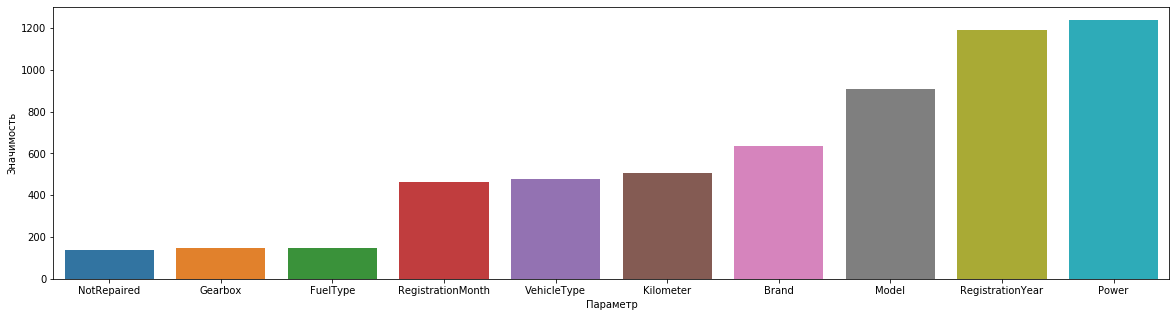

In [73]:
plt.figure(figsize=(20,5))
sns.barplot(stat.index, stat[0])
plt.xlabel('Параметр')
plt.ylabel('Значимость')
plt.show()

<div class="alert alert-block alert-success">
Здорово, очень наглядно. Можно еще упорядочить признаки по убыванию значимости.
</div>

**Вывод**: Исходный набор данных представляет собой таблицу размера (354369, 16). В исходном наборе данных имеется юольшое количество пропусков (108555), которые были либо просто выброшены, либо соответствувющим образом заполнены. Для построения модели были отброшены столбцы с датами (DateCrawled,DateCreated, LastSeen) и малоинформативные признаки (PostalCode, NumberOfPictures(тут все нули)).
Для анализа качества предсказания, скорости предсказания и времени обучения использовались следующие алгоритмы машинного обучения:


| Алгоритм| RMSE обучающий (cv)|RMSE тестовый|Время обучения (с)|Время предсказания (мс)|
| --------|:-------------:|:-----------:|:------------:| ----------------:|
|Линейная регрессия|2476|2477|3.18|135|
|Решающее дерево|2001|1983|0.343|14|
|Случайный лес|2693|2689|10.7|154|
|Градиентный бустинг|1539|1514|0.701|179|

Как видно из результатов наибольшую точность в  прогнозах даёт алгоритм градиентного бустинга, он обучается так же быстро как и решающее дерево, но делает более точные прогнозы. Данный алгоритм больше подходит для составлення финальной модели. Если необходимо быстро построить моделть и оценить результат, то можно использовать решающее дерево, так как оно даёт более высокую точноть, по сравнению с линейноной регрессиией и обучается гараздо быстрее ансамбля и бустинга.
Исходя из анализа результатов градиентного бустинга видно, что при установке цены следует акцентироваться на годе регистрации автомобиля, мощности двигателя, модели, бренде

<div class="alert alert-block alert-success">
Таблица замечательная! В первой колонке должно быть RMSE на кросс-валидации. Лучшую по качеству модель следует выбирать, ориентируясь именно на него.
</div>

<div class="alert alert-block alert-warning">
<b>Итоговый комментарий:</b> 

Илья, в целом, структура проекта верная, осталось доработать детали.

</div>

## Чек-лист проверки

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x]  Jupyter Notebook открыт
- [ ]  Весь код выполняется без ошибок
- [ ]  Ячейки с кодом расположены в порядке исполнения
- [ ]  Выполнена загрузка и подготовка данных
- [ ]  Выполнено обучение моделей
- [ ]  Есть анализ скорости работы и качества моделей